# **Load model and data**

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

from gensim.models import KeyedVectors

from xgboost import XGBClassifier

from ripser import Rips
from persim import PersistenceImager

from utils import *

In [2]:
vectorize_function = KeyedVectors.load_word2vec_format('glove.6B.300d.word2vec.txt', binary=False).get_vector

In [3]:
df = pd.read_csv('AI_Human_part.csv', lineterminator='\n')
df.head()

,text,generated
0,dear principal i understand that you may not ...,0.0
1,i favor in to changing election by popular vot...,0.0
2,exploring venus is a challenge and studying th...,0.0
3,why drivers should not access their phones whi...,0.0
4,to the principal our school should not ban ce...,0.0


# **Process data**

In [4]:
sample_size = 3000
num_top_words = 120

In [5]:
human_texts = df['text'][:sample_size]
ai_texts = df['text'][-sample_size:]

In [6]:
human_clouds = [get_text_point_cloud(human_text, vectorize_function, num_top_words=num_top_words) for human_text in human_texts]
ai_clouds = [get_text_point_cloud(ai_text, vectorize_function, num_top_words=num_top_words) for ai_text in ai_texts]

In [7]:
datas = []
datas.extend(human_clouds)
datas.extend(ai_clouds)

In [8]:
warnings.filterwarnings("ignore")

rips = Rips(maxdim=1, coeff=2)
rips.metric_ = 'cosine'
h1 = [rips.fit_transform(data)[1] for data in datas]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


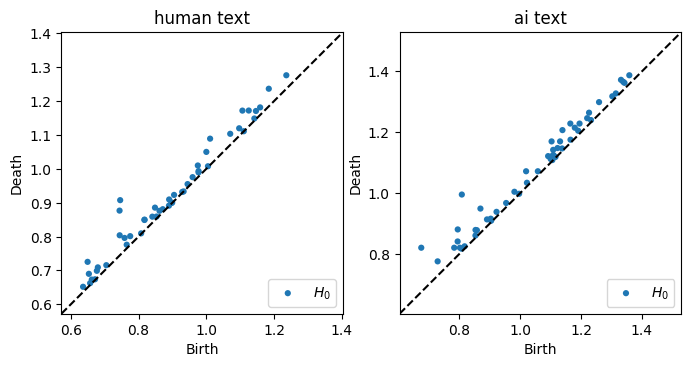

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(121)

rips.plot(h1[0], show=False)
plt.title("human text")

plt.subplot(122)
rips.plot(h1[-1], show=False)
plt.title("ai text")

plt.show()

In [10]:
pimgr = PersistenceImager()

pimgr.pixel_size = 0.015
pimgr.kernel_params = {'sigma': 0.001}

In [11]:
pimgr.fit(h1)
imgs = pimgr.transform(h1)

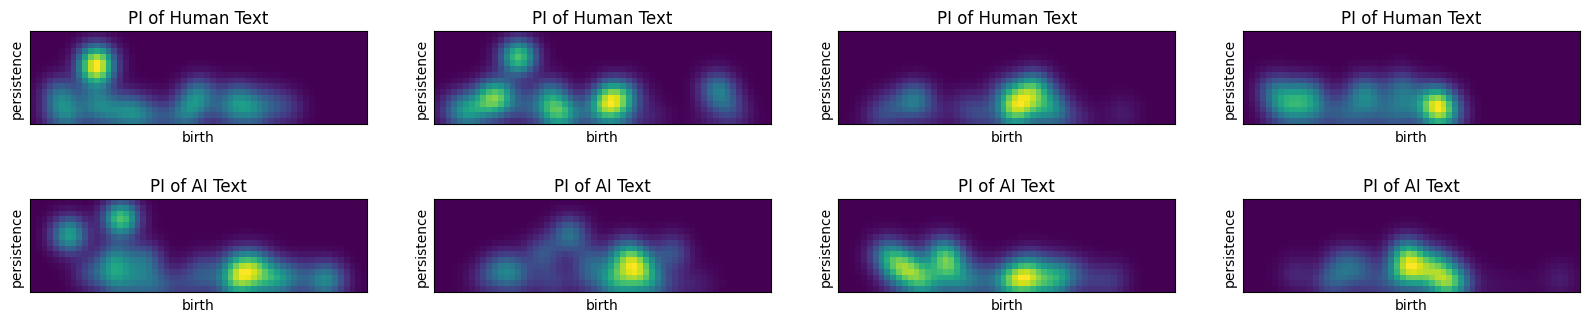

In [12]:
plot_PIs(imgs, pimgr)

In [13]:
imgs_array = np.array([img.flatten() for img in imgs])

labels = np.zeros(sample_size*2)
labels[sample_size:] = 1

X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.25, random_state=42)

# **Fit models**

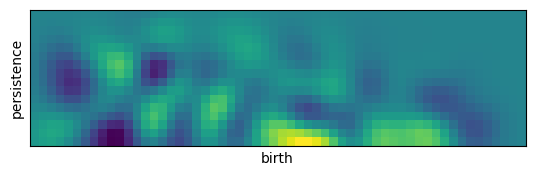

In [14]:
# Gradient Boosting
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=4)
xgb.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=11, random_state=42)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(C=2400)
lr.fit(X_train, y_train)

inverse_image = np.copy(lr.coef_).reshape(pimgr.resolution)
pimgr.plot_image(inverse_image)
plt.show()

In [15]:
models = [('Logistic Regression', lr), ('Random Forest', rf), ('Gradient Boosting', xgb)]

for name, model in models:
    print(f'model: {name}')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

model: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       769
         1.0       0.83      0.81      0.82       731

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500

model: Random Forest
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       769
         1.0       0.87      0.79      0.83       731

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500

model: Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       769
         1.0       0.87      0.81      0.84       731

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
w

# **Ensemble**

In [16]:
models = [('rf', rf), ('lr', lr), ('xgb', xgb)]

meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=models,
    final_estimator=meta_model,
    cv=5
)
stacking_model.fit(X_train, y_train)

stack_score_train = round(stacking_model.score(X_train, y_train), 3)
stack_score_test = round(stacking_model.score(X_test, y_test), 3)

print(f'score on train: {stack_score_train}')
print(f'score on test: {stack_score_test}')

y_pred = stacking_model.predict(X_test)

score on train: 0.944
score on test: 0.849


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       769
         1.0       0.87      0.82      0.84       731

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



## **Honorable mention**

In [18]:
ensemble = VotingClassifier(
    estimators=models[:2],
    voting='hard',
)
ensemble.fit(X_train, y_train)
y_pred_voting = ensemble.predict(X_test)

print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85       769
         1.0       0.89      0.76      0.82       731

    accuracy                           0.83      1500
   macro avg       0.84      0.83      0.83      1500
weighted avg       0.84      0.83      0.83      1500



# **More examples**

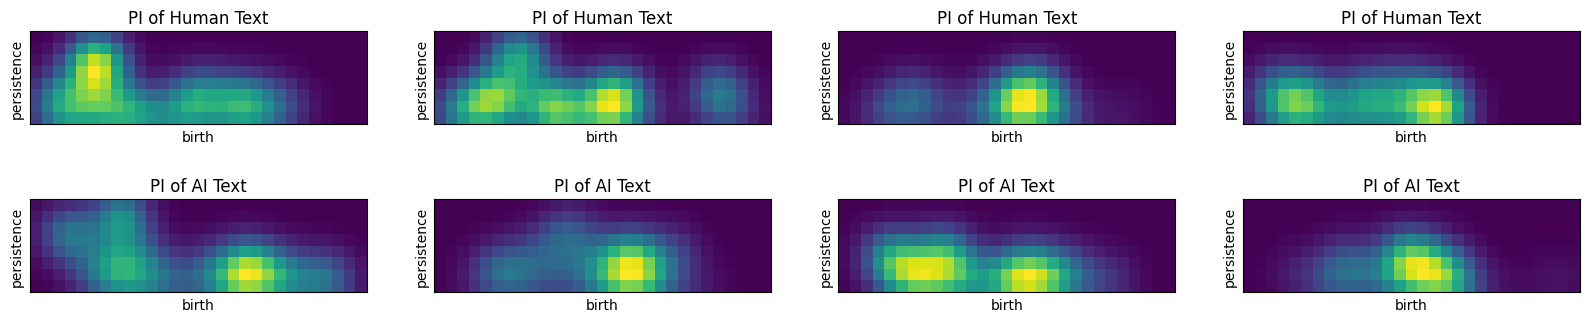

In [19]:
plot_PIs_for_params(h1, pixel_size=0.03, sigma=0.0025)

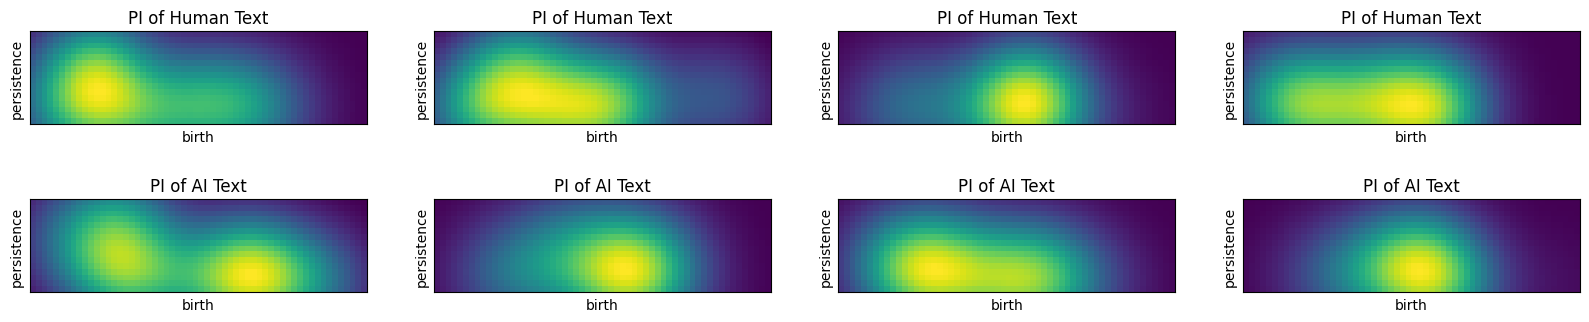

In [20]:
plot_PIs_for_params(h1, pixel_size=0.015, sigma=0.01)

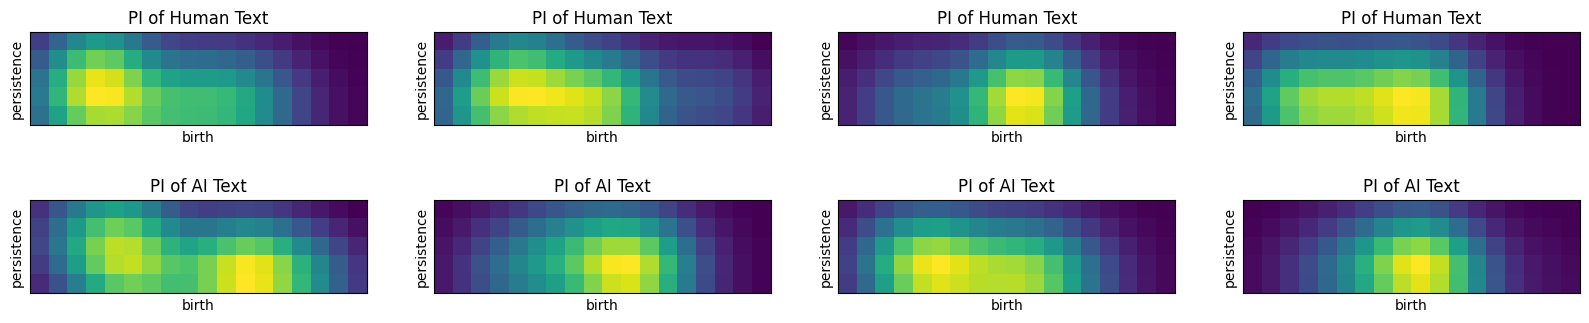

In [21]:
plot_PIs_for_params(h1, pixel_size=0.05, sigma=0.01)